In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import *
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import *
from  scipy import stats


In [2]:
def Feature_Encoder(X, cols):
    for c in cols:
        lbl = LabelEncoder()
        lbl.fit(list(X[c].values))
        X[c] = lbl.transform(list(X[c].values))
    return X


In [3]:
def one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df


In [4]:
weatherData = pd.read_csv("weather.csv")
taxiRidersData = pd.read_csv("taxi-rides.csv")
taxiRidersData.time_stamp = pd.to_datetime(taxiRidersData.time_stamp,unit="ms")
taxiRidersData.time_stamp = taxiRidersData.time_stamp.dt.hour
weatherData.time_stamp = pd.to_datetime(weatherData.time_stamp,unit='s')
weatherData.time_stamp = weatherData.time_stamp.dt.hour


'taxiRidersData.time_stamp = pd.to_datetime(taxiRidersData.time_stamp,unit="ms")\ntaxiRidersData.time_stamp = taxiRidersData.time_stamp.dt.hour\n#taxiRidersData.time_stamp=taxiRidersData.time_stamp.astype("datetime64[h]")\nweatherData.time_stamp = pd.to_datetime(weatherData.time_stamp,unit=\'s\')\nweatherData.time_stamp = weatherData.time_stamp.dt.hour'

weatherData.rain has 82% null values
groub weatherData by location since it's the common column between two CSVs


In [5]:
# weatherData
weatherData.dropna()
taxiRidersData.dropna(axis=0, inplace=True)
avgWeather = weatherData.groupby("location").mean().reset_index(drop=False)
avgWeather = avgWeather.drop(['time_stamp'], axis=1)
sourceWeather = avgWeather.rename(
    columns={
        'location': 'source',
        'rain': 'source_rain',
        'temp': 'source_temp',
        'clouds': 'source_clouds',
        'pressure': 'source_pressure',
        'humidity': 'source_humidity',
        'wind': 'source_wind'
    }
)

destinationWeather = avgWeather.rename(
    columns={
        'location': 'destination',
        'rain': 'destination_rain',
        'temp': 'destination_temp',
        'clouds': 'destination_clouds',
        'pressure': 'destination_pressure',
        'humidity': 'destination_humidity',
        'wind': 'destination_wind'

    }
)

sourceWeather


,source,source_temp,source_clouds,source_pressure,source_rain,source_humidity,source_wind
0,Back Bay,39.082122,0.678432,1008.447820,0.056012,0.764073,6.778528
1,Beacon Hill,39.047285,0.677801,1008.448356,0.057097,0.765048,6.810325
2,Boston University,39.047744,0.679235,1008.459254,0.054688,0.763786,6.692180
3,Fenway,38.964379,0.679866,1008.453289,0.054863,0.767266,6.711721
4,Financial District,39.410822,0.676730,1008.435793,0.061352,0.754837,6.860019
5,Haymarket Square,39.067897,0.676711,1008.445239,0.059593,0.764837,6.843193
6,North End,39.090841,0.676730,1008.441912,0.058712,0.764054,6.853117
7,North Station,39.035315,0.676998,1008.442811,0.056542,0.765545,6.835755
8,Northeastern University,38.975086,0.678317,1008.444168,0.054197,0.767648,6.749426
9,South Station,39.394092,0.677495,1008.438031,0.059537,0.755468,6.848948


In [6]:
"""data = taxiRidersData.merge(weatherData,left_on=['time_stamp','destination'],right_on=['time_stamp','location'])\
    .merge(weatherData,left_on=['time_stamp','source'],right_on=['time_stamp','location'])"""
data = taxiRidersData.merge(sourceWeather, on='source')\
    .merge(destinationWeather, on="destination")


# DATA PRE-PROCESSING


since product_id and name have 100% correlation we can remove one of them as it is considered dublication

In [7]:
for i  in ((data.product_id + " " + data.name).unique()):
    print(i)
data.drop(['product_id'],axis=1,inplace=True)
data.drop(['id'],axis=1,inplace=True)

997acbb5-e102-41e1-b155-9df7de0a73f2 UberPool
lyft_premier Lux
55c66225-fbe7-4fd5-9072-eab1ece5e23e UberX
6c84fd89-3f11-4782-9b50-97c468b19529 Black
9a0e7b09-b92b-4c41-9779-2ad22b4d779d WAV
6f72dfc5-27f1-42e8-84db-ccc7a75f6969 UberXL
lyft_plus Lyft XL
lyft_lux Lux Black
6d318bcc-22a3-4af6-bddd-b409bfce1546 Black SUV
lyft Lyft
lyft_line Shared
lyft_luxsuv Lux Black XL


from the figer we can see that thier are multipl features that are considered highly correlated with each other that we can drop which are:

* source_humidity -> source_temp
* source_wind ->  source_cloud
* destination_humidity -> destination_temp
* destination_wind -> destination_cloud

In [8]:
corr = data.corr()
plt.figure(figsize=(16, 5))
dataplot = sns.heatmap(data.corr(), annot=True, linewidths=1)

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

In [10]:
cor_matrix = data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.92)]
data = data.drop(to_drop, axis=1)

## remove outliers

In [11]:
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

In [12]:
cols = ['distance',
'source_clouds',
'source_temp',
'source_pressure',
'source_rain',
'destination_clouds',
'destination_temp',
'destination_pressure',
'destination_rain'
]
data = data[Remove_Outlier_Indices(data).all(1)]

/tmp/ipykernel_124516/4081425533.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))


## Encdoing Data

Using mean Encdoing to encode data since it has great balance between efficency and model complexity

In [13]:
data.name = data.name.map(data.groupby('name')['price'].mean())
data.source = data.source.map(data.groupby('source')['price'].mean())
data.destination = data.destination.map(data.groupby('destination')['price'].mean())
data.cab_type = data.cab_type.map(data.groupby('cab_type')['price'].mean())


In [14]:
X = data.drop(['price'], axis=1)
Y = data['price']


Index(['name'], dtype='object')


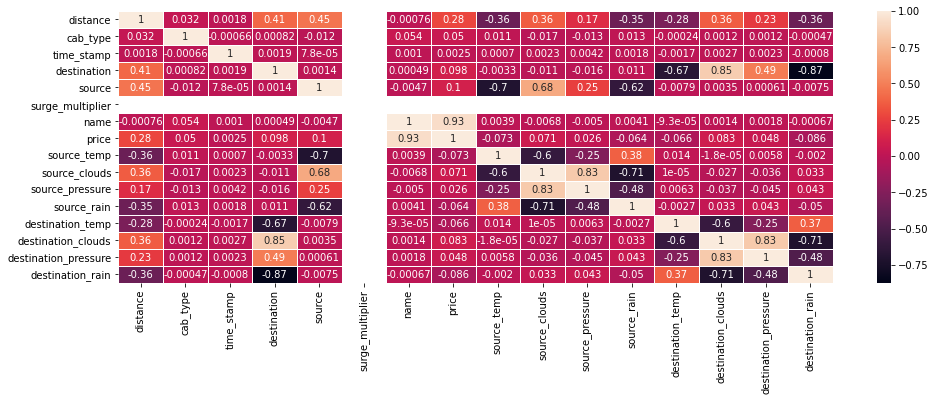

In [39]:
corr = data.corr()
plt.figure(figsize=(16, 5))
dataplot = sns.heatmap(data.corr(), annot=True, linewidths=1)
top_feature = corr.index[abs(corr['price']) > 0.6]
top_feature = top_feature.drop("price")
#X = X[top_feature]
print(top_feature)


# Model training and result

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, shuffle=True, random_state=10)


In [20]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)


In [21]:
model = LinearRegression()
model.fit(X_train, y_train)

print("Train R^2 Score: {:.5f}".format(model.score(X_train, y_train)))
print("Test R^2 Score: {:.5f}".format(model.score(X_test, y_test)))


Train R^2 Score: 0.94570
Test R^2 Score: 0.94588


In [36]:
def model_trial(X_train, X_test, y_train, y_test, model, degree=30):
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)

    model.fit(X_train_poly, y_train)

    y_train_predicted = model.predict(X_train_poly)
    prediction = model.predict(poly_features.fit_transform(X_test))

    train_err = metrics.mean_squared_error(y_train, y_train_predicted)
    test_err = metrics.mean_squared_error(y_test, prediction)
    train_acc = metrics.r2_score(y_train, y_train_predicted)
    test_acc = metrics.r2_score(y_test, prediction)
    print('Train subset (MSE) for degree {}: '.format(degree), train_err)
    print('Test subset (MSE) for degree {}: '.format(degree), test_err)
    print('Train subset (acc) for degree {}: '.format(degree), train_acc)
    print('Test subset (acc) for degree {}: '.format(degree), test_acc)
    #print("Train R^2 Score: {:.5f}".format(model.score(X_train_poly, y_train)))


In [37]:
#model_trial(X_train, X_test, y_train, y_test, linear_model.LinearRegression())
model_trial(X_train, X_test, y_train, y_test, linear_model.Ridge(), degree=3)


Train subset (MSE) for degree 3:  2.4902468009220864
Test subset (MSE) for degree 3:  2.51230043746261
Train subset (acc) for degree 3:  0.9636788236146006
Test subset (acc) for degree 3:  0.9636385778487063
